In [53]:
import pymongo
import spacy
import decouple
import glob
import datetime
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm
from pytrends.request import TrendReq
import tweepy

config = decouple.AutoConfig(' ')
nlp = spacy.load("en_core_web_lg")
pytrends = TrendReq(hl='en-US', tz=360)

In [23]:
gsearch = 'photo'
pytrends.build_payload([gsearch], timeframe='now 4-H')
qrys = pytrends.related_queries()[gsearch]['rising']['query'].values
trend = ' '.join([_q.replace(gsearch, '').replace('  ', ' ').strip() for _q in qrys])
trend

'raimohan raimohan parida raimohan family raimohan parida daughter name mon album appareil mi portable printer box livre cadre impression appareil jetable google traduction maeva ghennam de sa mère twitter scandinavian montage de profil brad pitt gq frames couple mere maeva max more maxmore bts'

In [61]:
client = pymongo.MongoClient(config('MONGODB_URI'))
client.list_database_names()
db = client.Cluster0
db.list_collection_names()

['test', 'pix']

In [62]:
colpix = db.pix
colpix.count_documents({})

348

In [63]:
# cursor = colpix.find(
#     {'$text': {'$search': 'happy'}}, 
#     {'score': {'$meta': 'textScore'}}
# )

# cursor.sort([('score', {'$meta': 'textScore'})])

In [64]:
pixs = list(colpix.find({ 'posted_at': {'$exists': False}})); len(pixs)

347

In [66]:
sims = []
for _p in tqdm(pixs):
    sims.append((_p['hash'], nlp(trend).similarity(nlp(_p['labels'] + ' ' + _p['colors']))))
    
sims = sorted(sims, key=lambda x: -x[1])
sims[:5]

  0%|          | 0/347 [00:00<?, ?it/s]

[('6cf4902f0a6b70294ccf3e791d252b9c926b023106f401cf9bdb0d978d614462',
  0.47323158358843787),
 ('46bbcbac5af4e9d8b4311acaa4cf0274e8e250f0dbecf9ba94a714d131eaaad4',
  0.46897226339225884),
 ('5c4991af35030a6ff6c8443607b51afae64149a1ecf2149a83b7d46a179c6258',
  0.4595933819114926),
 ('9ea7921dc0278491431c5f4d4a3f70d8d717be7cb80eedc424c5c120326aec60',
  0.45543094962207276),
 ('e72190fb04445540835f332bc2650cba7cf9712ec40c55a7cedae70725f075e6',
  0.45361934443150737)]

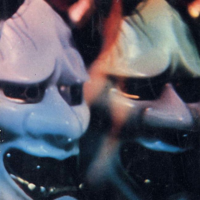

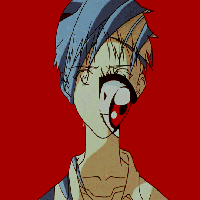

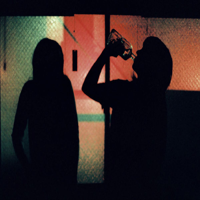

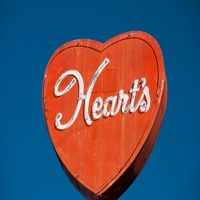

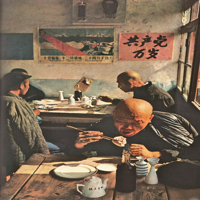

In [65]:
for _fname, _ in sims[:5]:
    _path = glob.glob('imgs/archive/' + _fname + '.*')[0]
    _img = Image.open(_path)
    _img = _img.resize((200, 200))
    display(_img)

In [54]:
_hash = sims[0][0]
pix = colpix.find_one({ 'hash': _hash }); pix

{'_id': ObjectId('62b54d3ec7b38aac0d7c8bc6'),
 'labels': 'eyebrow mouth jaw eyewear gesture art cool happy entertainment electric_blue performing_arts artist fictional_character selfie fun painting cg_artwork movie carmine pleased fiction facial_hair supervillain darkness personal_protective_equipment visual_arts flesh',
 'urls': ['https://2chan.jp/akuma/src/1389885183967.png',
  'https://pm1.narvii.com/6858/9650600c85f177d8f240a844805e53ae2eca80c4v2_hq.jpg',
  'https://64.media.tumblr.com/tumblr_lz3vvo2KRR1qzn0kbo1_1280.png',
  'https://i.pinimg.com/736x/31/53/61/315361a409a7243d7dbd08af62ba0081.jpg',
  'https://pbs.twimg.com/media/E34Uz9yXIAQNq9v.jpg',
  'https://78.media.tumblr.com/tumblr_m8z2256j8o1r2vza2o1_500.png',
  'https://i.pinimg.com/originals/7f/17/dc/7f17dc0ffd416aac07d631ead66e3de1.png',
  'https://i.pinimg.com/736x/7f/17/dc/7f17dc0ffd416aac07d631ead66e3de1--penny-arcade-japanese-culture.jpg',
  'https://i.pinimg.com/474x/7f/17/dc/7f17dc0ffd416aac07d631ead66e3de1--penny-a

In [55]:
url = pix['urls'][0]; url

'https://2chan.jp/akuma/src/1389885183967.png'

In [56]:
pix_upload = glob.glob('imgs/archive/' + _hash + '.*')[0]; pix_upload

'imgs/archive/e0620a1da6deabd8eabef6e8871aae350f3b19f1a03b95f0ab5fceeaa47cecfb.jpg'

In [57]:
status = 'crawled from ' + url; status

'crawled from https://2chan.jp/akuma/src/1389885183967.png'

In [58]:
bearer_token = config('TWITTER_BEARER_TOKEN')
consumer_key = config('TWITTER_CONSUMER_KEY')
consumer_secret = config('TWITTER_CONSUMER_SECRET')
access_token = config('TWITTER_ACCESS_TOKEN')
access_token_secret = config('TWITTER_ACCESS_TOKEN_SECRET')

auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
api = tweepy.API(auth)

In [59]:
media = api.media_upload(filename=pix_upload)
api.create_media_metadata(media.media_id_string, _hash)
api.update_status(status=status, media_ids=[media.media_id_string]);

In [60]:
colpix.update_one(
    { 'hash': _hash }, 
    { '$set': { 'posted_at': datetime.datetime.utcnow() }}
)